In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.16.1
Keras: 3.3.3
KerasCV: 0.9.0


In [23]:
class CFG:
    verbose = 1
    seed = 42
    neg_sample = 0.01
    pos_sample = 5.0 
    preset = "efficientnetv2_b2_imagenet"
    image_size = [128, 128]
    epochs = 8
    batch_size = 256
    lr_mode = "cos"
    class_name = ["target"]
    num_classes = 1

In [24]:
keras.utils.set_random_seed(CFG.seed)

In [25]:
BASE_PATH = "/kaggle/input/isic-2024-challenge"

In [26]:
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')

/tmp/ipykernel_30/2866554477.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


In [27]:
df = df.ffill()

In [28]:
display(df.head(5))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [29]:
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


In [30]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize = True)*100)

positive_df = df.query("target==0").sample(frac = CFG.neg_sample, random_state = CFG.seed)
negative_df = df.query("target==1").sample(frac = CFG.pos_sample, replace = True, random_state = CFG.seed)

df = pd.concat([positive_df, negative_df], axis = 0).sample(frac = 1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Calss Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

In [31]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(df["target"]), y = df["target"])


In [32]:
class_weights

array([0.74519591, 1.51959288])

In [33]:
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


In [34]:
import h5py

training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

In [35]:
isic_id = df.isic_id.iloc[0]

byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....


In [36]:
df.isic_id.iloc[0]

'ISIC_1111537'

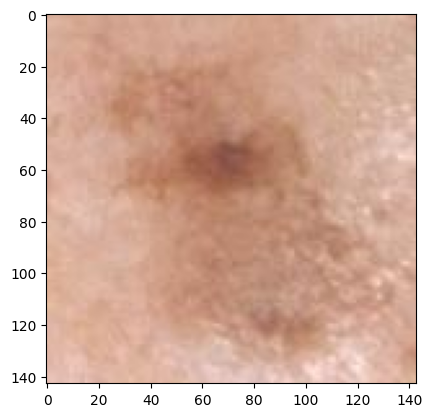

In [37]:
nparr = np.frombuffer(byte_string, np.uint8)
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[..., ::-1]
plt.imshow(image)

In [38]:
from sklearn.model_selection import StratifiedGroupKFold
    
df = df.reset_index(drop = True)
df["fold"] = -1
sfl = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = CFG.seed)
for i, (train_idx, valid_idx) in enumerate(sfl.split(df, y = df.target, groups = df.patient_id)):
    df.loc[valid_idx, "fold"] = int(i)

training_df = df.query("fold!=0")
validation_df = df.query("fold==0")

print(f"num train : {len(training_df)} num valid : {len(validation_df)}")

num train : 4706 num valid : 1266


In [39]:
training_df.target.value_counts()

target
0    3088
1    1618
Name: count, dtype: int64

In [40]:
validation_df.target.value_counts()

target
0    919
1    347
Name: count, dtype: int64

In [41]:
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [42]:
def build_augmenter():
    
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor = (0.02, 0.06), width_factor = (0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode = "horizontal")
    ]
    aug_layers = [keras_cv.layers.RandomApply(x, rate = 0.5) for x in aug_layers]
    
    augmenter = keras_cv.layers.Augmenter(aug_layers)
    
    def augment(inp, labels):
        images = inp["images"]
        aug_data = {"images" : images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, labels
    return augment

In [43]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [44]:
print("# Training:")
training_features = dict(training_df[FEAT_COLS])
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5, training_features, 
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = dict(validation_df[FEAT_COLS])
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5, validation_features,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

In [45]:
feature_space = keras.utils.FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

In [46]:
training_ds_with_no_labels = training_ds.map(lambda x, _ : x["features"])
feature_space.adapt(training_ds_with_no_labels)

In [47]:
for x , _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed shape", preprocessed_x.shape)
    print("preprocessed type", preprocessed_x.dtype)

preprocessed shape (256, 71)
preprocessed type <dtype: 'float32'>


In [48]:
training_ds = training_ds.map(
    lambda x, y:({
        "images" : x["images"],
        "features" : feature_space(x["features"])
    }, y), num_parallel_calls = tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y :({
        "images" : x["images"],
        "features" : feature_space(x["features"])
    }, y), num_parallel_calls = tf.data.AUTOTUNE)


In [49]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


In [50]:
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy(label_smoothing = 0.2)

In [51]:
image_input = keras.Input(shape = (*CFG.image_size, 3), name = "images")
feat_input = keras.Input(shape = (feature_space.get_encoded_features().shape[1],), name = "features")
inp = {"images": image_input, "features": feat_input}

backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

x2 = keras.layers.Dense(96, activation = "selu")(feat_input)
x2 = keras.layers.Dense(128, activation = "selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

concat = keras.layers.Concatenate()([x1, x2])

out = keras.layers.Dense(1, activation = "sigmoid", dtype = "float32")(concat)
model = keras.models.Model(inp, out)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    loss = loss,
    metrics = [auc],
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,537 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,790,239 (33.53 MB)

 Trainable params: 8,707,951 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

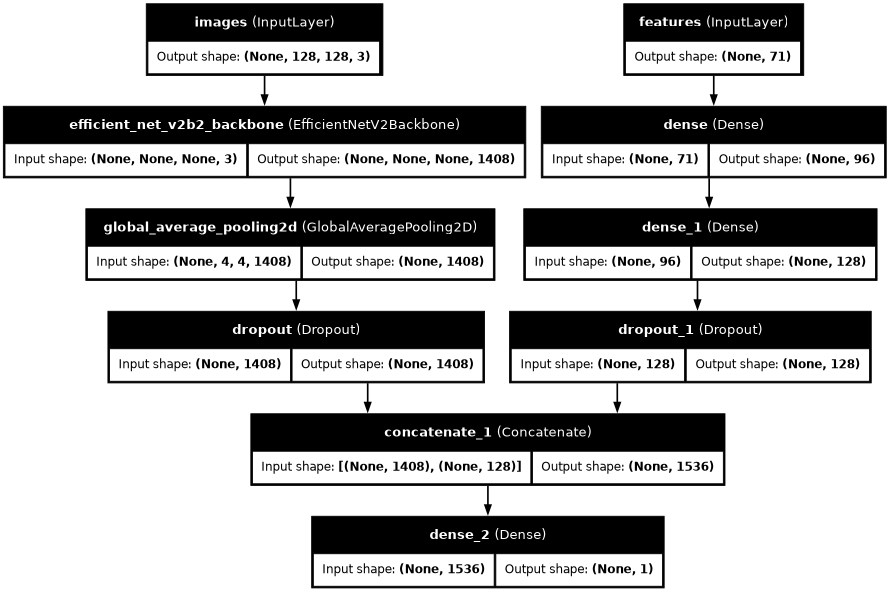

In [52]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True, dpi = 60)

In [53]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

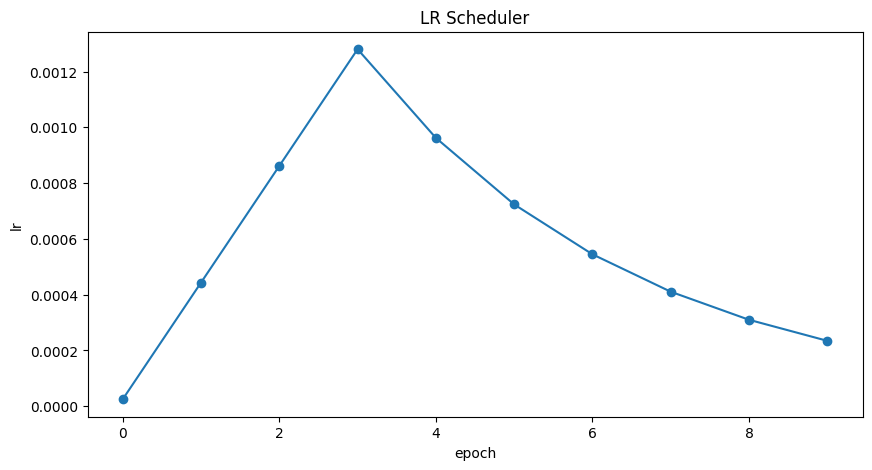

In [54]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)


In [55]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

In [56]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/8


I0000 00:00:1729400665.257438      98 service.cc:145] XLA service 0x7c64a006f580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729400665.257524      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729400665.257530      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729400777.155380      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 72 bytes spill stores, 72 bytes spill loads

I0000 00:00:1729400777.271716      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 577ms/step - auc_1: 0.7706 - loss: 0.6233 - val_auc_1: 0.7316 - val_loss: 0.6438 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 565ms/step - auc_1: 0.9526 - loss: 0.4678 - val_auc_1: 0.7903 - val_loss: 0.5601 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 572ms/step - auc_1: 0.9897 - loss: 0.3923 - val_auc_1: 0.9040 - val_loss: 0.4987 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 570ms/step - auc_1: 0.9960 - loss: 0.3651 - val_auc_1: 0.8926 - val_loss: 0.5072 - learning_rate: 9.6200e-04
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - auc_1: 0.9982 - loss: 0.3529 - val_auc_1: 0.8888 - val_loss: 0.5262 - learning_rate: 7.2350e-04
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 574ms/step - auc_1: 0.9990 - loss: 0.3474 - val_auc_1: 0.8787 - val_loss: 0.5294 - learning_rate: 5.4462e-04
Epoch 8/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - auc_1: 0.9994 - loss: 0.3443 - val_auc_1: 0.8949 - val_loss:

In [60]:
best_score = max(history.history['val_auc_1'])
best_epoch = np.argmax(history.history['val_auc_1']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.90399
Best Epoch: 4
############################


In [64]:
# Testing
print("# Testing:")
testing_features = dict(testing_df[FEAT_COLS])
testing_ids = testing_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                        testing_features, batch_size=CFG.batch_size,
                         shuffle=False, augment=False, cache=False)
# Apply feature space processing
testing_ds = testing_ds.map(
    lambda x: {"images": x["images"],
               "features": feature_space(x["features"])}, num_parallel_calls=tf.data.AUTOTUNE)

# Testing:


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

In [65]:
preds = model.predict(testing_ds).squeeze()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


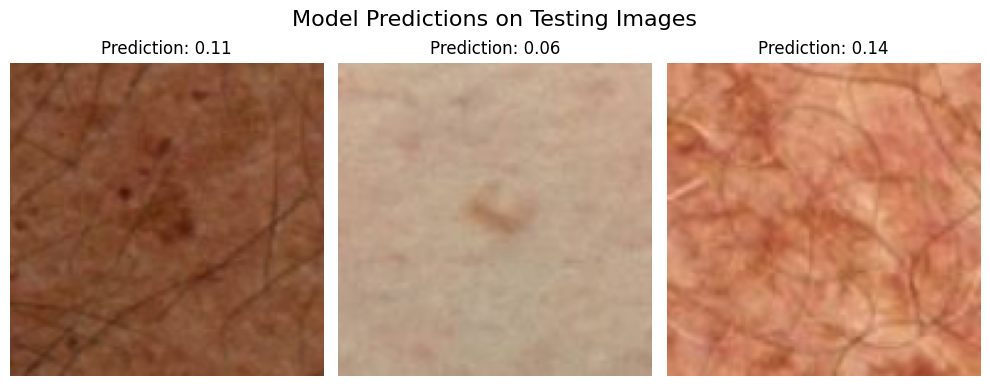

In [66]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(images[i])  # Show image
    plt.title(f'Prediction: {preds[i]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

In [67]:
pred_df = testing_df[["isic_id"]].copy()
pred_df["target"] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["isic_id"]].copy()
sub_df = sub_df.merge(pred_df, on="isic_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,isic_id,target
0,ISIC_0015657,0.106776
1,ISIC_0015729,0.059613
2,ISIC_0015740,0.135194
